In [123]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [91]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Exploratory data analysis

By looking at our data we see there are some invalid values. To quantify them we look at the different features and compute the percentage of invalid values for each one of them.

In [92]:
def print_percentages(array):
    for j in range(array.shape[1]):
        count_col = 0
        for i in range(array.shape[0]):
            if array[i,j] == -999:
                count_col += 1
        count_col = (count_col/array.shape[0])*100
        if (count_col > 0) : 
            print(f'For the feature {j+1} : {count_col} % of missing values')
        
print_percentages(tX)

For the feature 1 : 15.245600000000001 % of missing values
For the feature 5 : 70.9828 % of missing values
For the feature 6 : 70.9828 % of missing values
For the feature 7 : 70.9828 % of missing values
For the feature 13 : 70.9828 % of missing values
For the feature 24 : 39.9652 % of missing values
For the feature 25 : 39.9652 % of missing values
For the feature 26 : 39.9652 % of missing values
For the feature 27 : 70.9828 % of missing values
For the feature 28 : 70.9828 % of missing values
For the feature 29 : 70.9828 % of missing values


It also seems that some elements in feature 23 (PRI_jet_num) and 30 (PRI_jet_all_pt) have value 0 or 1 for elements with missing value

In [93]:
zero_percentage_23 = (np.count_nonzero((tX[:, 22] == 1) | (tX[:, 22] == 0)) / tX.shape[0]) * 100
zero_percentage_30 = (np.count_nonzero(tX[:, 29] == 0) / tX.shape[0]) * 100

print(f'For the feature 23 : {zero_percentage_23} % of zero values')
print(f'For the feature 30 : {zero_percentage_30} % of zero values')

For the feature 23 : 70.9828 % of zero values
For the feature 30 : 39.9652 % of zero values


We notice that the elements seem to fit in four different categories. 15 % of our elements are missing values in the first feature, about 40% are missing values in features 24, 25, 26 and 30, and about 70% are missing values in features 5, 6, 7, 13, 23, 27, 28 and 29.

### Data pre-processing

Because each of the different categories of elements will most likely affect the output in a different way, we choose to split our data in 4 sub-samples based on those categories to train a model for each of them separately.

In [94]:
def build_mask(tx) : 
    mask1 = tx[:, 0] == -999
    mask2 = (tx[:, 23] == -999) & (tx[:, 0] != -999)
    mask3 = (tx[:, 4] == -999) & (tx[:, 23] != -999) & (tx[:, 0] != -999)
    mask4 = (tx[:, 4] != -999) & (tx[:, 23] != -999) & (tx[:, 0] != -999)
    
    return mask1, mask2, mask3, mask4

def build_subsample(tx, mask) :
    feature_mask = []
    for j in range(tx.shape[1]):
        if (j == 22) :
            feature_mask.append(not ((0 in tx[mask][:,j]) | (1 in tx[mask][:,j])))
        elif (j == 29) :
            feature_mask.append(not ((0 in tx[mask][:,j])))
        else :
            feature_mask.append(not (-999 in tx[mask][:,j]))
        
    subsample = tx[mask][:, feature_mask]
    
    return subsample
        
def split_categories(tx) :
    m1, m2, m3, m4  = build_mask(tx)
    
    s1 = build_subsample(tx, m1)
    s2 = build_subsample(tx, m2)
    s3 = build_subsample(tx, m3)
    s4 = build_subsample(tx, m4)
    
    return s1, s2, s3, s4, m1, m2, m3, m4

In [95]:
x1, x2, x3, x4, mask1, mask2, mask3, mask4 = split_categories(tX)
masks = np.array([mask1, mask2, mask3, mask4])
print("Subsample x1 has ", x1.shape[0], " elements, ", x1.shape[1], " features and no invalid values: ", (not(-999 in x1)))
print("Subsample x2 has ", x2.shape[0], " elements, ", x2.shape[1], " features and no invalid values: ", (not(-999 in x2)))
print("Subsample x3 has ", x3.shape[0], " elements, ", x3.shape[1], " features and no invalid values: ", (not(-999 in x3)))
print("Subsample x4 has ", x4.shape[0], " elements, ", x4.shape[1], " features and no invalid values: ", (not(-999 in x4)))

Subsample x1 has  38114  elements,  17  features and no invalid values:  True
Subsample x2 has  73790  elements,  18  features and no invalid values:  True
Subsample x3 has  69982  elements,  22  features and no invalid values:  True
Subsample x4 has  68114  elements,  30  features and no invalid values:  True


To process our data we choose to normalize it, i.e transforming all values to be between 0 and 1. This allows for a more homogeneous dataset and avoids large values that could result in overflow or other issues

In [96]:
#normalize the matrix
def normalize(tx) :
    tx_normalized = tx.copy()
    for feature in tx_normalized.T :
        diff = np.amax(feature) - np.amin(feature)
        normalized_feature = (feature - np.amin(feature))/diff
        if ((diff != 0) & (diff != 1)) : #avoids normalizing categorical features resulting in singular matrices
            feature[:] = normalized_feature
    return tx_normalized

In [97]:
x1_normalized = normalize(x1)
x2_normalized = normalize(x2)
x3_normalized = normalize(x3)
x4_normalized = normalize(x4)

In [1367]:
# standardize the matrix 
def standardize(tX, normalized = False) :
    tX_standardized = tX.copy()
    for feature in tX_standardized.T : 
        mask = (feature != -999)
        i_mask = (feature == -999)
        feature[i_mask] = feature[mask].mean() # replace undetermined value by mean of other values in the feature column
        feature[:] = (feature-feature.mean())/feature.std() # standardize
        if normalized :
            feature[:] = (feature - np.amin(feature))/(np.amax(feature) - np.amin(feature)) # normalize
    tX_standardized.T[22] = tX.T[22] # Avoid standardization on categorical feature
    tX_standardized = np.delete(tX_standardized, 7343, 0) #remove outlier
    # tX_standardized = np.c_[tX_standardized, np.ones((tX_standardized.shape[0], 1))] # Add row of ones for better regression
    return tX_standardized

### Features cleaning
We don't need that, keeping just in case

Even after standardizing our data we might not want certain columns or rows. For this reason we create some masks to apply to our dataset that could improve accuracy

In [100]:
mask_dict = {}
no_mask = np.full(tX_standardized_af.shape[1], True)
# no_mask[30] = False
mask_dict["no_mask"] = no_mask

In [101]:
# Create mask removing columns with unvalid data
remove_na_mask = []
for j in range(tX.shape[1]):
    remove_na_mask.append(not (-999 in tX[:,j]))
# remove_na_mask.append(False) # for 1 column

mask_dict["remove_na_mask"] = remove_na_mask

In [102]:
# Create mask removing columns with unvalid data except the first one because it has only 15% on error
remove_error_mask = []
for j in range(tX.shape[1]):
    remove_error_mask.append(not (-999 in tX[:,j]))
remove_error_mask[0] = True
# remove_error_mask.append(False) # for 1 column

mask_dict["remove_error_mask"] = remove_error_mask

We notice some features do not have invalid data but do have a 0 value for almost every row containing some invalid data. We create a mask removing all of them in case it offers better accuracy on our methods.

In [103]:
# Create mask removing all columns with unvalid or 0 data
remove_all_mask = []
for j in range(tX.shape[1]):
    remove_all_mask.append(not (-999 in tX[:,j]))
remove_all_mask[29] = False
remove_all_mask[22] = False
# remove_all_mask.append(False)

mask_dict["remove_all_mask"] = remove_all_mask

We now want to create a mask selecting only the features bringing the most information about y. To do so we calculate the correlation of each of the features with y and select only the ones with best correlation.

In [104]:
# Sort features based on their correlation with y
correlations = np.zeros(tX_standardized_af.shape[1] - 1)
for i in range(len(correlations)) :
    correlations[i] = np.corrcoef(y, tX_standardized_af.T[i])[0][1]
sorted_features_correlations = np.array(sorted(list(enumerate(correlations)), key=lambda x: -np.abs(x[1])))
sorted_features_indexes = np.array(sorted_features[:, 0], dtype = int)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [105]:
# Create a mask based on the n features with best correlation with y
n = 15
best_corr_mask = sorted(sorted_features_indexes[:n])


mask_dict["best_corr_mask"] = best_corr_mask 
best_corr_mask

NameError: name 'sorted_features_indexes' is not defined

In [106]:
# for i, feature in enumerate(tX_standardized.T) :
#    print("Feature " , i+1)
#    plt.plot(feature[:1000], y[:1000], 'kp', alpha = 0.006)
#    plt.show()

### Useful functions

In [98]:
''' Calculate accuracy of model'''
def accuracy_function(weights, x, y) :
    y_pred = predict_labels(weights, x)
    return np.count_nonzero(y == y_pred) / (y.shape[0])

In [99]:
def total_accuracy(weights, x, y, masks) :
    total_count = 0
    for i in range(weights.shape[0]) :
        y_pred = predict_labels(weights[i], x[i])
        total_count += np.count_nonzero(y[masks[i]] == y_pred)
    return total_count / (y.shape[0])

In [100]:
''' Create a dictionary for the different methods'''
methods = {
    "least_squares_GD" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: least_squares_GD(y, tx, initial_w, max_iters, gamma)),
    "least_squares_SGD" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: least_squares_SGD(y, tx, initial_w, max_iters, gamma)),
    "least_squares": (lambda y, tx, lambda_, initial_w, max_iters, gamma: least_squares(y, tx)),
    "ridge_regression" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: ridge_regression(y, tx, lambda_)),
    "logistic_regression" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: logistic_regression(y, tx, initial_w, max_iters, gamma)),
    "reg_logistic_regression" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma))   
}

In [120]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(k_fold, method, y, tx,  degree = 1, lambda_ = 0, max_iters = 1, gamma = 0):
    """return the loss of ridge regression."""
    
    # define lists to store the accuracy of training data and test data for the given parameter
    acc_tr_param = []
    acc_te_param = []
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed = 1)
    tx_poly = build_all(tx, degree)
    initial_w = np.zeros(tx_poly.shape[1])
    
    for k in range(k_fold):
        
        te_indice = k_indices[k]
        tr_indice = np.delete(k_indices, k, 0)
        tr_indice = np.ndarray.flatten(tr_indice)

        tr_x = tx_poly[tr_indice]
        tr_y = y[tr_indice]
        te_x = tx_poly[te_indice]
        te_y = y[te_indice]
        
        w, loss = method(tr_y, tr_x, lambda_, initial_w, max_iters, gamma)

        acc_tr_param.append(accuracy_function(w, tr_x, tr_y))
        acc_te_param.append(accuracy_function(w, te_x, te_y))
    
    return np.mean(acc_tr_param), np.mean(acc_te_param)

In [121]:
# Compute the optimal parameter for 
def determine_parameter(method, tx, y, degrees = [1], lambdas = [0], gammas = [0], k_fold = 4, max_iters = 1, name = 'x'):
    
    # define a matrix to store the accuracy of training data and test data
    acc_tr_matrix = np.zeros(shape = (len(degrees), len(lambdas), len(gammas)))
    acc_te_matrix = np.zeros(shape = (len(degrees), len(lambdas), len(gammas)))
    initial_w = np.zeros(tx.shape[1])
    for h, degree in enumerate(degrees) :
        for i, lambda_ in enumerate(lambdas) :
            for j, gamma in enumerate(gammas) :
                acc_tr_matrix[h, i, j], acc_te_matrix[h, i, j] = cross_validation(k_fold, method, y, tx,  degree, lambda_, max_iters, gamma )
    
    max_acc_index = np.unravel_index(acc_te_matrix.argmax(), acc_te_matrix.shape)
    
    max_acc = acc_te_matrix[max_acc_index]
    
    degree = degrees[max_acc_index[0]]
    lambda_ = lambdas[max_acc_index[1]]
    gamma = gammas[max_acc_index[2]]
    
    if len(degrees) > 1:
        if (lambda_ != 0) : print("Lambda = ", lambda_, '\n')
        if (gamma != 0) : print("Gamma = ", gamma, '\n')
        title = 'Optimal degree for ' + name
        degree_plot = plot_train_test(acc_tr_matrix[:, max_acc_index[1], max_acc_index[2]], acc_te_matrix[:, max_acc_index[1], max_acc_index[2]], degrees, title, 'degree')
        print("Optimal degree :", degree)
    if len(lambdas) > 1:
        if (degree != 1) : print("Degree = ", degree, '\n')
        if (gamma != 0) : print("Gamma = ", gamma, '\n')
        title = 'Optimal lambda for ' + name
        lambdas_plot = plot_train_test(acc_tr_matrix[max_acc_index[0], :, max_acc_index[2]], acc_te_matrix[max_acc_index[0], :, max_acc_index[2]], lambdas, title, 'lambda', log = True)
        print("Optimal lambda :", lambda_)
    if len(gammas) > 1:
        if (degree != 1) : print("Degree = ", degree, '\n')
        if (lambda_ != 0) : print("Lambda = ", lambda_, '\n')
        title = 'Optimal gamma for' + name
        gammas_plot = plot_train_test(acc_tr_matrix[max_acc_index[0], max_acc_index[1], :], acc_te_matrix[max_acc_index[0], max_acc_index[1], :], gammas, title, 'gamma')
        print("Optimal gamma :", gamma)
    print("Max accuracy :", max_acc)
    
    return degree, lambda_, gamma

In [103]:
def analyze_method(method, X, y, masks, degrees = [1], lambdas = [0], gammas = [0], max_iters = 1, k_fold = 4, name = "x") :
    optimal_degree = np.zeros(X.shape[0], dtype = int)
    optimal_lambda = np.zeros(X.shape[0])
    optimal_gamma = np.zeros(X.shape[0])
    X_poly = []
    W = []
    L = []
    
    for i in range(X.shape[0]) :
        temp_name = name + str(i+1)
        optimal_degree[i], optimal_lambda[i], optimal_gamma[i] = determine_parameter(method, X[i], y[masks[i]], degrees = degrees, lambdas = lambdas, gammas = gammas, max_iters = max_iters, k_fold = k_fold, name = temp_name)
        X_poly.append(build_multi_poly(X[i], optimal_degree[i]))
        initial_w = np.zeros(X_poly[i].shape[1])
        w_temp, l_temp = method(y[masks[i]], X_poly[i], optimal_lambda[i], initial_w, max_iters, optimal_gamma[i])
        W.append(w_temp)
        L.append(l_temp)
    X_poly = np.array([X_poly[0], X_poly[1], X_poly[2], X_poly[3]])
    W = np.array([W[0], W[1], W[2], W[3]])
    L = np.array([L[0], W[1], W[2], W[3]])
    
    
    accuracy = total_accuracy(W, X_poly, y, masks)
    print("Accuracy for least squares gradient with optimal parameters is :", accuracy * 100, '%')
    
    return W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy

### Least square with polynomial expansion on features

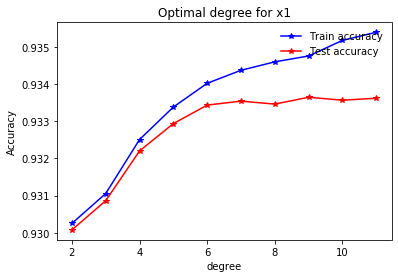

Optimal degree : 9
Max accuracy : 0.9336429471032746


LinAlgError: Singular matrix

In [104]:
d1, l1, g1 = determine_parameter(methods["least_squares"], x1_normalized, y[mask1], degrees = np.arange(2, 12), name = "x1")
d2, l2, g2 = determine_parameter(methods["least_squares"], x2_normalized, y[mask2], degrees = np.arange(2, 12), name = "x2")
d3, l3, g3 = determine_parameter(methods["least_squares"], x3_normalized, y[mask3], degrees = np.arange(2, 12), name = "x3")
d4, l4, g4 = determine_parameter(methods["least_squares"], x4_normalized, y[mask4], degrees = np.arange(2, 12), name = "x4")

In [105]:
x1_poly = build_multi_poly(x1_normalized, d1)
x2_poly = build_multi_poly(x2_normalized, d2)
x3_poly = build_multi_poly(x3_normalized, d3)
x4_poly = build_multi_poly(x4_normalized, d4)

w1, loss = least_squares(y[mask1], x1_poly)
w2, loss = least_squares(y[mask2], x2_poly)
w3, loss = least_squares(y[mask3], x3_poly)
w4, loss = least_squares(y[mask4], x4_poly)

weights = np.array([w1, w2, w3, w4])
tx = np.array([x1_poly, x2_poly, x3_poly, x4_poly])
accuracy = total_accuracy(weights, tx, y, masks)
print("Accuracy for least squares with optimal parameters is :", accuracy * 100, '%')

NameError: name 'd2' is not defined

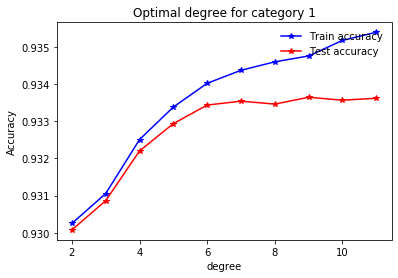

Optimal degree : 9
Max accuracy : 0.9336429471032746


LinAlgError: Singular matrix

In [106]:
X = np.array([x1_normalized, x2_normalized, x3_normalized, x4_normalized])
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["least_squares"], X, y, masks, degrees = np.arange(2, 12), name = "category ")

### Least square gradient with polynomial expansion on features

In [ ]:
d1, l1, g1 = determine_parameter(methods["least_squares_GD"], x1_normalized, y[mask1], degrees = np.arange(2, 13), gammas = np.logspace(-9, -2, 15), max_iters = 10, name = "x1")
d2, l2, g2 = determine_parameter(methods["least_squares_GD"], x2_normalized, y[mask2], degrees = np.arange(2, 13), gammas = np.logspace(-9, -2, 15), max_iters = 10, name = "x2")
d3, l3, g3 = determine_parameter(methods["least_squares_GD"], x3_normalized, y[mask3], degrees = np.arange(2, 13), gammas = np.logspace(-9, -2, 15), max_iters = 10, name = "x3")
d4, l4, g4 = determine_parameter(methods["least_squares_GD"], x4_normalized, y[mask4], degrees = np.arange(2, 13), gammas = np.logspace(-9, -2, 15), max_iters = 10, name = "x4")


In [ ]:
x1_poly = build_multi_poly(x1_normalized, d1)
x2_poly = build_multi_poly(x2_normalized, d2)
x3_poly = build_multi_poly(x3_normalized, d3)
x4_poly = build_multi_poly(x4_normalized, d4)

w1, loss = least_squares_GD(y[mask1], x1_poly, np.zeros(x1_poly.shape[1]), 1000, g1)
w2, loss = least_squares_GD(y[mask2], x2_poly, np.zeros(x2_poly.shape[1]), 1000, g2)
w3, loss = least_squares_GD(y[mask3], x3_poly, np.zeros(x3_poly.shape[1]), 1000, g3)
w4, loss = least_squares_GD(y[mask4], x4_poly, np.zeros(x4_poly.shape[1]), 1000, g4)

weights = np.array([w1, w2, w3, w4])
tx = np.array([x1_poly, x2_poly, x3_poly, x4_poly])
accuracy = total_accuracy(weights, tx, y, masks)
print("Accuracy for least squares gradient with optimal parameters is :", accuracy * 100, '%')

### Ridge regression with polynomial expansion on features

Lambda =  7.196856730011513e-08 



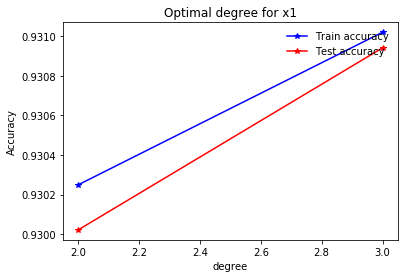

Optimal degree : 3
Degree =  3 



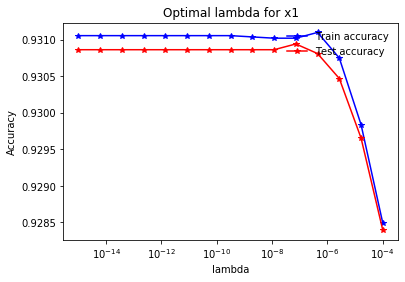

Optimal lambda : 7.196856730011513e-08
Max accuracy : 0.9309403862300587
Lambda =  1e-15 



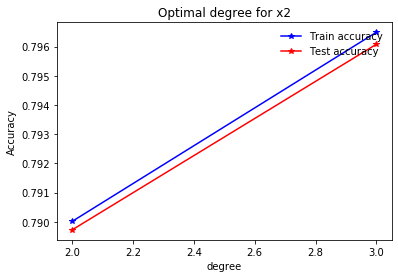

Optimal degree : 3
Degree =  3 



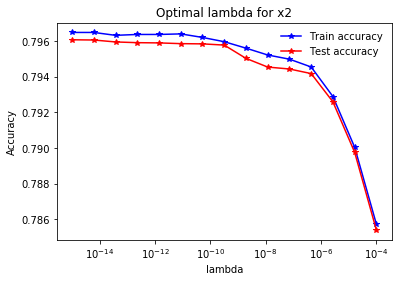

Optimal lambda : 1e-15
Max accuracy : 0.7960779530546973
Lambda =  1.3894954943731361e-12 



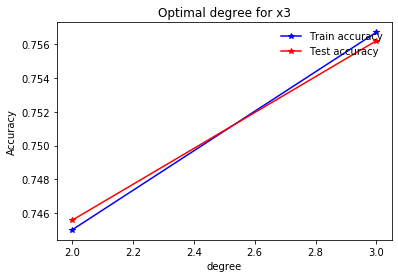

Optimal degree : 3
Degree =  3 



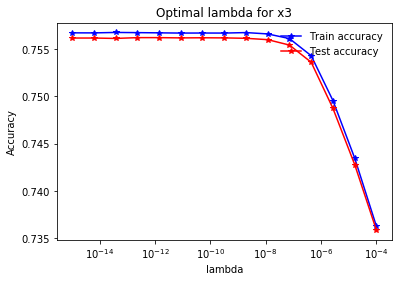

Optimal lambda : 1.3894954943731361e-12
Max accuracy : 0.7562160617319235
Lambda =  1.9306977288832458e-09 



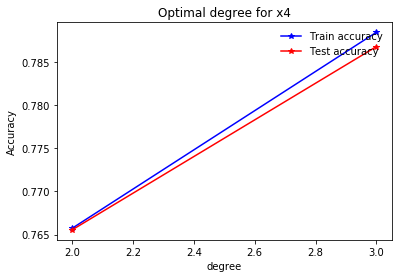

Optimal degree : 3
Degree =  3 



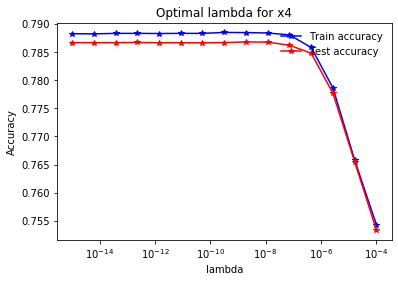

Optimal lambda : 1.9306977288832458e-09
Max accuracy : 0.786777660324172


In [110]:
d1, l1, g1 = determine_parameter(methods["ridge_regression"], x1_normalized, y[mask1], degrees = np.arange(2, 4), lambdas = np.logspace(-15, -4, 15), name = "x1")
d2, l2, g2 = determine_parameter(methods["ridge_regression"], x2_normalized, y[mask2], degrees = np.arange(2, 4), lambdas = np.logspace(-15, -4, 15), name = "x2")
d3, l3, g3 = determine_parameter(methods["ridge_regression"], x3_normalized, y[mask3], degrees = np.arange(2, 4), lambdas = np.logspace(-15, -4, 15), name = "x3")
d4, l4, g4 = determine_parameter(methods["ridge_regression"], x4_normalized, y[mask4], degrees = np.arange(2, 4), lambdas = np.logspace(-15, -4, 15), name = "x4")


In [111]:
x1_poly = build_multi_poly(x1_normalized, d1)
x2_poly = build_multi_poly(x2_normalized, d2)
x3_poly = build_multi_poly(x3_normalized, d3)
x4_poly = build_multi_poly(x4_normalized, d4)

w1, loss = ridge_regression(y[mask1], x1_poly, l1)
w2, loss = ridge_regression(y[mask2], x2_poly, l2)
w3, loss = ridge_regression(y[mask3], x3_poly, l3)
w4, loss = ridge_regression(y[mask4], x4_poly, l4)

weights = np.array([w1, w2, w3, w4])
tx = np.array([x1_poly, x2_poly, x3_poly, x4_poly])
accuracy = total_accuracy(weights, tx, y, masks)
print("Accuracy for ridge regression with optimal parameters is :", accuracy * 100, '%')

Accuracy for ridge regression with optimal parameters is : 80.342 %


Lambda =  6.105402296585339e-15 



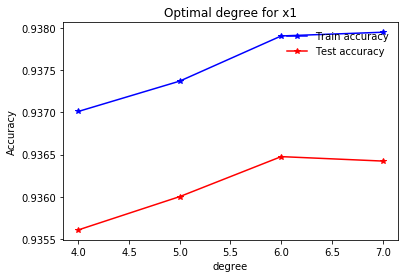

Optimal degree : 6
Degree =  6 



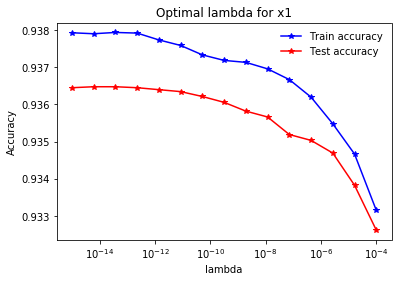

Optimal lambda : 6.105402296585339e-15
Max accuracy : 0.9364767002518891
Lambda =  6.105402296585339e-15 



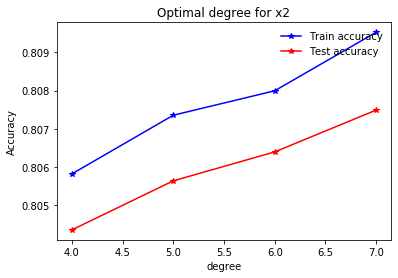

Optimal degree : 7
Degree =  7 



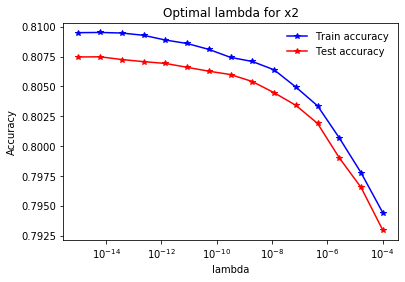

Optimal lambda : 6.105402296585339e-15
Max accuracy : 0.8074890226053016
Lambda =  1e-15 



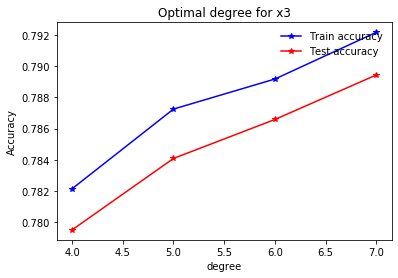

Optimal degree : 7
Degree =  7 



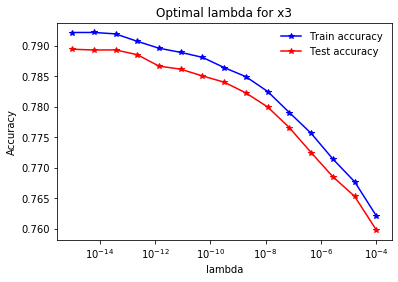

Optimal lambda : 1e-15
Max accuracy : 0.7894398399542726


LinAlgError: Singular matrix

In [128]:
d1, l1, g1 = determine_parameter(methods["ridge_regression"], x1_normalized, y[mask1], degrees = np.arange(4, 8), lambdas = np.logspace(-15, -4, 15), name = "x1")
d2, l2, g2 = determine_parameter(methods["ridge_regression"], x2_normalized, y[mask2], degrees = np.arange(4, 8), lambdas = np.logspace(-15, -4, 15), name = "x2")
d3, l3, g3 = determine_parameter(methods["ridge_regression"], x3_normalized, y[mask3], degrees = np.arange(4, 8), lambdas = np.logspace(-15, -4, 15), name = "x3")
d4, l4, g4 = determine_parameter(methods["ridge_regression"], x4_normalized, y[mask4], degrees = np.arange(4, 8), lambdas = np.logspace(-15, -4, 15), name = "x4")


In [129]:
x1_poly = build_all(x1_normalized, d1)
x2_poly = build_all(x2_normalized, d2)
x3_poly = build_all(x3_normalized, d3)
x4_poly = build_all(x4_normalized, d4)

w1, loss = ridge_regression(y[mask1], x1_poly, l1)
w2, loss = ridge_regression(y[mask2], x2_poly, l2)
w3, loss = ridge_regression(y[mask3], x3_poly, l3)
w4, loss = ridge_regression(y[mask4], x4_poly, l4)

weights = np.array([w1, w2, w3, w4])
tx = np.array([x1_poly, x2_poly, x3_poly, x4_poly])
accuracy = total_accuracy(weights, tx, y, masks)
print("Accuracy for ridge regression with optimal parameters is :", accuracy * 100, '%')

Accuracy for ridge regression with optimal parameters is : 82.3408 %


### Ridge regression with the first 10 columns and feature expension

In [ ]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degree = 12
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []
# disctionnary degree -> accuracy of the model on the test set given the lambda
acc = {}

rmse_min = np.inf
lambda_opt = 0

title = 'Ridge regression for polynomial 3'
# define parameter
lambdas = np.logspace(-9, -2, 15)

polynomial_features = PolynomialFeatures(degree)
# polynomial expension
train_poly_x = build_multi_poly(x_train, degree)
test_poly_x = build_multi_poly(x_test, degree)

for ind, lambda_ in enumerate(lambdas):
    
    w, loss = ridge_regression(y_train, train_poly_x, lambda_)
    
    # keep track of the loss for ploting
    rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
    rmse_te.append(compute_rmse(y_test, test_poly_x, w))
    acc[lambda_] = accuracy(w, test_poly_x, y_test)
    if rmse_test < rmse_min:
        rmse_min = rmse_test
        weights = w
        lambda_opt = lambda_
    
plot_train_test(rmse_tr, rmse_te, lambdas, title)

In [ ]:
acc

In [ ]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)

# define parameter
lambdas = np.logspace(-9, -2, 15)
degrees = np.arange(1, 13)


acc_max = 0
for ind_degree, degree in enumerate(degrees):
    acc_tr = []
    acc_te = []
    for ind, lambda_ in enumerate(lambdas):
        train_poly_x = build_multi_poly(x_train, degree)
        test_poly_x = build_multi_poly(x_test, degree)

        w, loss = ridge_regression(y_train, train_poly_x, lambda_)

        acc_tr.append(accuracy(w, train_poly_x, y_train))
        acc_test = accuracy(w, test_poly_x, y_test)
        acc_te.append(acc_test)
        if acc_test > acc_max:
            weights = w
    print('accuracy test for degree', degree, '= ', acc_te)
    title = 'Ridge regression train test accuracy'
    plot_train_test(acc_tr, acc_te, lambdas, title)

In [ ]:
tX_temp = tX_standardized_af
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)

# define parameter
lambdas = np.logspace(-9, -2, 15)
degree = 12

acc_max = 0

acc_tr = []
acc_te = []
for ind, lambda_ in enumerate(lambdas):
    train_poly_x = build_multi_poly(x_train, degree)
    test_poly_x = build_multi_poly(x_test, degree)

    w, loss = ridge_regression(y_train, train_poly_x, lambda_)

    acc_tr.append(accuracy(w, train_poly_x, y_train))
    acc_test = accuracy(w, test_poly_x, y_test)
    acc_te.append(acc_test)
    if acc_test > acc_max:
        weights = w
print('accuracy test for degree', degree, '= ', acc_te)
title = 'Ridge regression train test accuracy'
plot_train_test(acc_tr, acc_te, lambdas, title)

In [ ]:
tX_temp = tX_standardized_af
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)

# define parameter
lambdas = np.logspace(-9, -2, 15)
degree = 11

acc_max = 0

acc_tr = []
acc_te = []
for ind, lambda_ in enumerate(lambdas):
    train_poly_x = build_multi_poly(x_train, degree)
    test_poly_x = build_multi_poly(x_test, degree)

    w, loss = ridge_regression(y_train, train_poly_x, lambda_)

    acc_tr.append(accuracy(w, train_poly_x, y_train))
    acc_test = accuracy(w, test_poly_x, y_test)
    acc_te.append(acc_test)
    if acc_test > acc_max:
        weights = w
print('accuracy test for degree', degree, '= ', acc_te)
title = 'Ridge regression train test accuracy'
plot_train_test(acc_tr, acc_te, lambdas, title)

### Logistic regression with the first 10 columns and extended features

In [ ]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degree = 3
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []
# disctionnary degree -> accuracy of the model on the test set given the lambda
acc = {}

rmse_min = np.inf
lambda_opt = 0

title = 'Ridge regression for polynomial 3'
# define parameter
lambdas = np.logspace(-9, -2, 15)

polynomial_features = PolynomialFeatures(degree)
# polynomial expension
train_poly_x = polynomial_features.fit_transform(x_train)
test_poly_x = polynomial_features.fit_transform(x_test)


train_poly_x = polynomial_features.fit_transform(x_train)
test_poly_x = polynomial_features.fit_transform(x_test)
weights, loss = logistic_regression(y, tX_temp, initial_w, 1000, 0.0000001)

# keep track of the loss for ploting
rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
rmse_te.append(compute_rmse(y_test, test_poly_x, w))
acc[lambda_] = accuracy(w, test_poly_x, y_test)
if rmse_test < rmse_min:
    rmse_min = rmse_test
    weights = w
    lambda_opt = lambda_
    
plot_train_test(rmse_tr, rmse_te, lambdas, title)

### Logistic regression with columns removed

In [ ]:
# polynomial expension
train_poly_x = build_multi_poly(tX_standardized_af[:, manual_mask], 7)
initial_w = np.zeros(train_poly_x.shape[1])
x_train, x_test, y_train, y_test = split_data(train_poly_x, y, 0.7, seed = 1)


weights, loss = logistic_regression(y_train, x_train, initial_w, 1000, 0.001)



In [ ]:
y_pred = predict_labels(weights, x_test)
np.count_nonzero(y_test == y_pred) / (y_pred.shape[0])

In [ ]:
print(weights)

In [ ]:
w_0 = np.zeros(tX_temp.shape[1])
w_0[mask] = weights
weights = w_0

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
#standardize tX_test
tX_test_standardized = standardize(tX_test)
tX_test_standardized_af = standardize(tX_test, affected = True)

In [ ]:
# extended feature here degree 4
tX_test = build_multi_poly(tX_test_standardized_af, 11)

In [ ]:
OUTPUT_PATH = '../data/submission_file.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)